# Skin Cancer: Malignant vs Benign
This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.

In [ ]:
%matplotlib inline

import os
import gc
from PIL import Image

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras.applications import VGG16
from sklearn.utils import check_random_state
from scipy import stats



from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


# Set the random seeds
np.random.seed(0)
tf.random.set_seed(0)
random_state = check_random_state(0)


import time
start_time = time.time()
end_time = time.time()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Content

The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

In [ ]:

train_imgs, test_imgs = [], []
train_labels, test_labels = [], []

for img_path in os.listdir('/content/drive/MyDrive/cancer_dataset/train/benign'):
    train_imgs.append('/content/drive/MyDrive/cancer_dataset/train/benign/' + img_path)
    train_labels.append(0)

for img_path in os.listdir('/content/drive/MyDrive/cancer_dataset/train/malignant'):
    train_imgs.append('/content/drive/MyDrive/cancer_dataset/train/malignant/' + img_path)
    train_labels.append(1)

for img_path in os.listdir('/content/drive/MyDrive/cancer_dataset/test/benign'):
    test_imgs.append('/content/drive/MyDrive/cancer_dataset/test/benign/' + img_path)
    test_labels.append(0)

for img_path in os.listdir('/content/drive/MyDrive/cancer_dataset/test/malignant'):
    test_imgs.append('/content/drive/MyDrive/cancer_dataset/test/malignant/' + img_path)
    test_labels.append(1)

train_imgs, test_imgs = np.array(train_imgs), np.array(test_imgs)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)

class_distribution = np.bincount(np.concatenate([train_labels, test_labels]))


## Data selection

Because of the size of the dataset I merge the train and the test sets to slice only 10% of the whole training data as the test set.

Then I slice 7% of the train set to use it for validation.

In [ ]:
# Load the images to memory
xtrain, xtest = [], []
ytrain, ytest = train_labels, test_labels

for filename in tqdm.tqdm(train_imgs):
    xtrain.append(np.array(Image.open(filename)))

for filename in tqdm.tqdm(test_imgs):
    xtest.append(np.array(Image.open(filename)))

del train_imgs, test_imgs, train_labels, test_labels
xtrain, xtest = np.array(xtrain), np.array(xtest)

# Merge and split train and test set to have more train data
data = np.concatenate([xtrain, xtest])
labels = np.concatenate([ytrain, ytest])

# Spliting data to train, validation and test values
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=.1, random_state=0)
xtra, xval, ytra, yval = train_test_split(xtrain, ytrain, test_size=.05, random_state=0, shuffle=False)

gc.collect()
print('Shape of the new train set:', xtra.shape)
print('Shape of the new test set:', xtest.shape)
print('Shape of the validation set:', xval.shape)

100%|██████████| 660/660 [00:04<00:00, 142.69it/s]


Shape of the new train set: (2818, 224, 224, 3)
Shape of the new test set: (330, 224, 224, 3)
Shape of the validation set: (149, 224, 224, 3)


Now I generate more training images by changing some of them.

In [ ]:
data_generator = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=[0.8, 1.1],
                                    fill_mode='nearest')

new_samples, new_labels = next(data_generator.flow(xtra, ytra, batch_size=len(xtra)))
xtra = np.concatenate([xtra, new_samples])
ytra = np.concatenate([ytra, new_labels])

del new_samples, new_labels
print('New number of training samples:', len(xtra))

New number of training samples: 5636


Use the simple normalization technique where we just divide each pixel value by `255`.

In [ ]:
# Normalizing values
xtra = xtra.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xval = xval.astype('float32') / 255.

print('Training data shape:', xtra.shape)
print('Min value:', xtra.min())
print('Max value:', xtra.max())

Training data shape: (2818, 224, 224, 3)
Min value: 0.0
Max value: 1.0


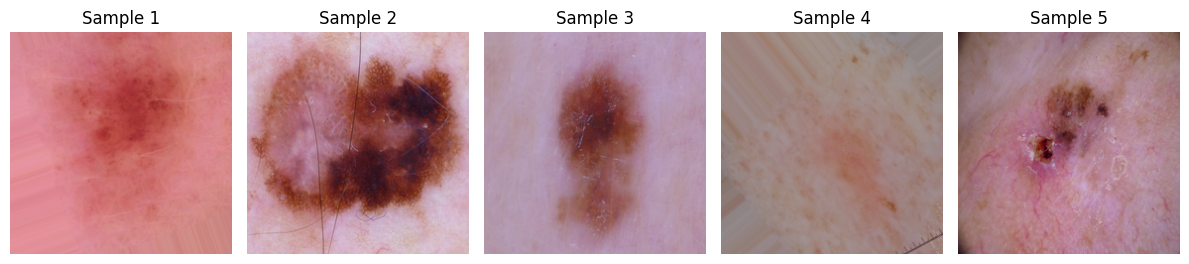

In [ ]:
import matplotlib.pyplot as plt

# Assuming xtra contains the augmented images

# Select a random sample of images to visualize
num_samples_to_visualize = 5
sample_indices = np.random.choice(len(xtra), num_samples_to_visualize, replace=False)

# Plot the sample images
fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(12, 4))

for i, index in enumerate(sample_indices):
    axes[i].imshow(xtra[index])
    axes[i].axis('off')
    axes[i].set_title('Sample {}'.format(i + 1))

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage import exposure, util

def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.convertScaleAbs(gray)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    result = cv2.bitwise_and(image, image, mask=opened)
    return result

def lighten(image, gamma=1.5):
    adjusted = exposure.adjust_gamma(image, gamma=gamma)
    return adjusted

def add_gaussian_noise(image, mean=0, var=0.01):
    noisy_image = util.random_noise(image, mode='gaussian', mean=mean, var=var)
    noisy_image = (255 * noisy_image).astype(np.uint8)
    return noisy_image

def generate_synthetic_background(image_shape):
    height, width, channels = image_shape
    background_type = np.random.choice(['color', 'gradient', 'pattern'])

    if background_type == 'color':
        # Solid color background
        background = np.random.randint(0, 256, size=(height, width, channels), dtype=np.uint8)

    elif background_type == 'gradient':
        # Gradient background
        background = np.zeros((height, width, channels), dtype=np.uint8)
        for i in range(height):
            color_value = int(255 * (i / height))
            background[i] = (color_value, color_value, color_value)

    elif background_type == 'pattern':
        # Simple geometric pattern
        background = np.zeros((height, width, channels), dtype=np.uint8)
        for i in range(0, height, 20):
            cv2.line(background, (0, i), (width, i),
                     (np.random.randint(256), np.random.randint(256), np.random.randint(256)), 2)

    return background

def apply_synthetic_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Generate a synthetic background
    background = generate_synthetic_background(image.shape)

    # Combine the original image with the generated background
    lesion_part = cv2.bitwise_and(image, image, mask=mask)
    inverse_mask = cv2.bitwise_not(mask)
    background_part = cv2.bitwise_and(background, background, mask=inverse_mask)
    combined = cv2.add(lesion_part, background_part)

    return combined

# Preprocess the training images
preprocessed_images_train = []
for image in xtra:
    hair_removed = remove_hair(image)
    lightened = lighten(hair_removed, gamma=1.5)
    noisy = add_gaussian_noise(lightened, var=0.02)
    background_replaced = apply_synthetic_background(noisy)
    preprocessed_images_train.append(background_replaced)

preprocessed_images_train = np.array(preprocessed_images_train)

# Preprocess the testing images
preprocessed_images_test = []
for image in xtest:
    hair_removed = remove_hair(image)
    lightened = lighten(hair_removed, gamma=1.5)
    noisy = add_gaussian_noise(lightened, var=0.02)
    background_replaced = apply_synthetic_background(noisy)
    preprocessed_images_test.append(background_replaced)

preprocessed_images_test = np.array(preprocessed_images_test)

# Preprocess the validation images
preprocessed_images_val = []
for image in xval:
    hair_removed = remove_hair(image)
    lightened = lighten(hair_removed, gamma=1.5)
    noisy = add_gaussian_noise(lightened, var=0.02)
    background_replaced = apply_synthetic_background(noisy)
    preprocessed_images_val.append(background_replaced)

preprocessed_images_val = np.array(preprocessed_images_val)


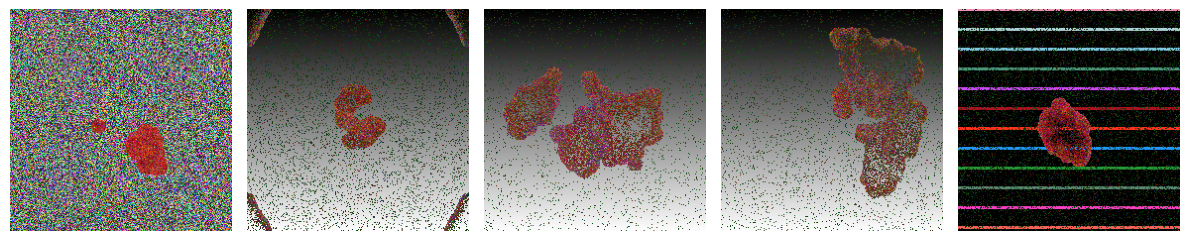

In [ ]:
import matplotlib.pyplot as plt

# Assuming preprocessed_images contains the preprocessed images

# Select a subset of images to display
num_images = 5
subset_images = preprocessed_images_train[:num_images]

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, image in enumerate(subset_images):
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

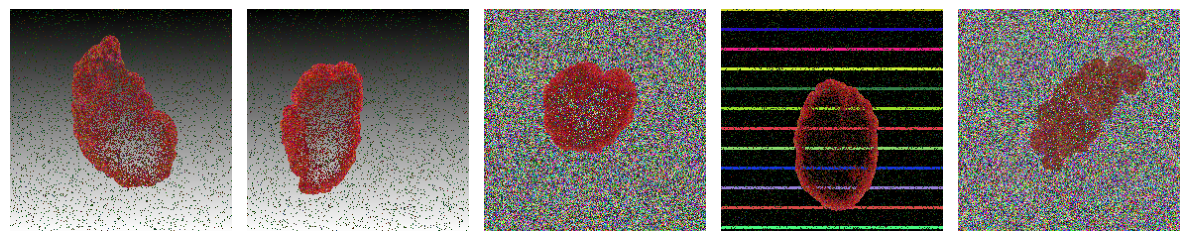

In [ ]:
import matplotlib.pyplot as plt

# Assuming preprocessed_images contains the preprocessed images

# Select a subset of images to display
num_images = 5
subset_images = preprocessed_images_test[:num_images]

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, image in enumerate(subset_images):
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

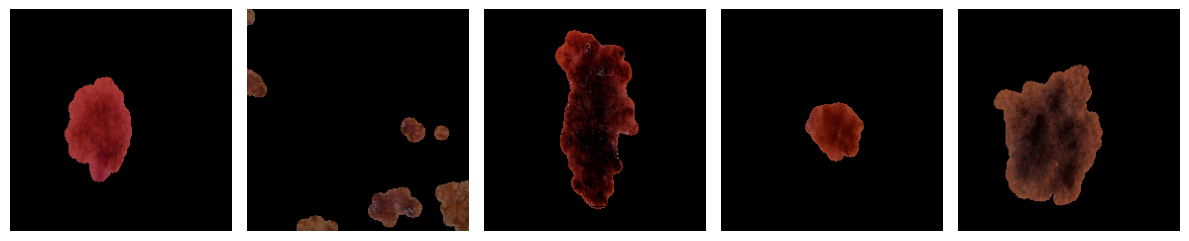

In [ ]:
import matplotlib.pyplot as plt

# Assuming preprocessed_images contains the preprocessed images

# Select a subset of images to display
num_images = 5
subset_images = preprocessed_images_val[:num_images]

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, image in enumerate(subset_images):
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()


**VGG16**

In [ ]:
# Constants
num_classes = 1  # Malignant and benign
input_shape = (224, 224, 3)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add an attention mechanism layer
x = GlobalAveragePooling2D()(base_model.output)
attention = Attention()([x, x])
x = tf.keras.layers.Multiply()([x, attention])
x = Dense(128, activation='relu')(x)
output_layer = Dense(num_classes, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()



# Train the model on GPU
with tf.device('/GPU:0'):
    history = model.fit(
        xtra, ytra,
        epochs=20,
        validation_data=(xval, yval)
    )


# Calculate the training time
training_time_vgg = end_time - start_time

# Add the training time to the history
history.history['training_time_vgg'] = training_time_vgg
print(training_time_vgg)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

Evaluate the model on test data to double check it's accuracy, and save it to this kernel.

In [ ]:
print('Accuracy on test set:', model.evaluate(xtest, ytest)[1])


11/11 [==============================] - 0s 24ms/step - loss: 0.6108 - acc: 0.8485
Accuracy on test set: 0.8484848737716675


In [ ]:
model.save('/content/drive/MyDrive/cancer_dataset/output/modelvgg.h5')

In [ ]:
## loading previously saved model after training
model_vgg = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/skin_cancer_model.h5')

In [ ]:
y_pred_vgg = model_vgg.predict(xtest)

11/11 [==============================] - 230s 20s/step


In [ ]:
y_pred_vgg = y_pred_vgg.flatten()

In [ ]:
y_pred_vgg = y_pred_vgg.astype(float)

In [ ]:
y_pred_vgg = np.where(y_pred_vgg > 0.5, 1, 0)

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_vgg)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[153  33]
 [ 11 133]]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_vgg))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       186
           1       0.80      0.92      0.86       144

    accuracy                           0.87       330
   macro avg       0.87      0.87      0.87       330
weighted avg       0.88      0.87      0.87       330



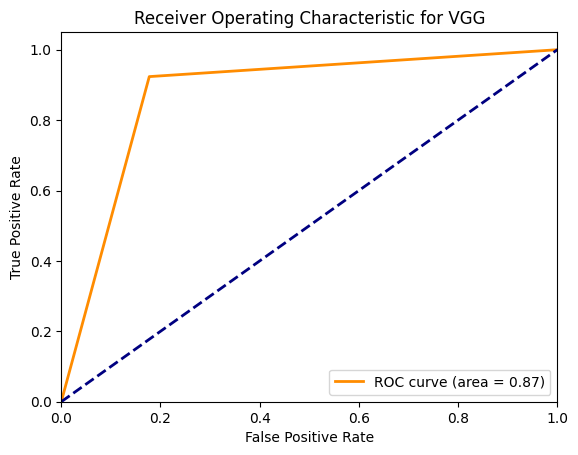

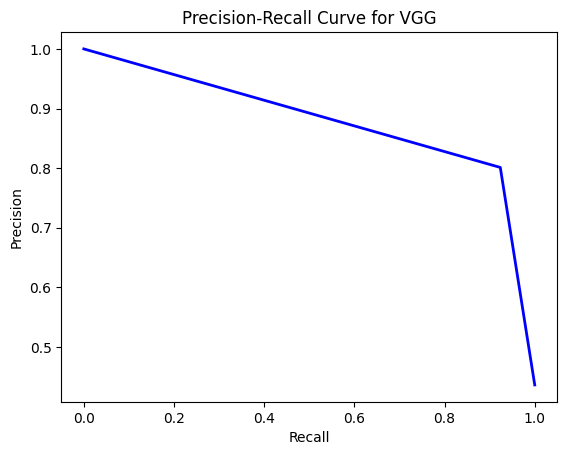

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_vgg)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_vgg)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"VGG"}')
    plt.show()

evaluate_model(model_vgg, xtest, ytest, "VGG")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_vgg[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8691
Standard deviation of accuracy: 0.0145
95% confidence interval for accuracy: [0.8637, 0.8745]


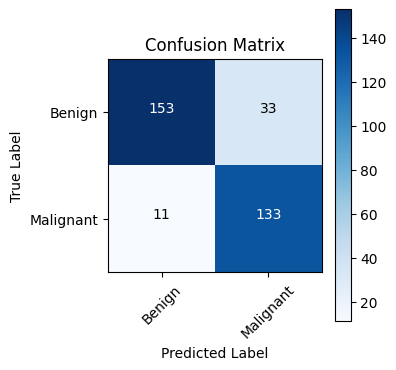

In [ ]:



# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_vgg)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**RESNET**

In [ ]:

# Build the model
model = Sequential()
model.add(ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet'))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Undefined shapes are not supported.

In [ ]:
model.save('/content/drive/MyDrive/cancer_dataset/output/modelresnet.h5')

In [ ]:
## loading previously saved model after training
model_resnet = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/modelresnet.h5')

In [ ]:
y_pred_resnet = model_resnet.predict(xtest)

11/11 [==============================] - 75s 7s/step


In [ ]:
y_pred_resnet = y_pred_resnet.flatten()

In [ ]:
y_pred_resnet = y_pred_resnet.astype(float)

In [ ]:
y_pred_resnet = np.where(y_pred_resnet > 0.5, 1, 0)

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_resnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[159  27]
 [ 43 101]]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_resnet))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       186
           1       0.79      0.70      0.74       144

    accuracy                           0.79       330
   macro avg       0.79      0.78      0.78       330
weighted avg       0.79      0.79      0.79       330



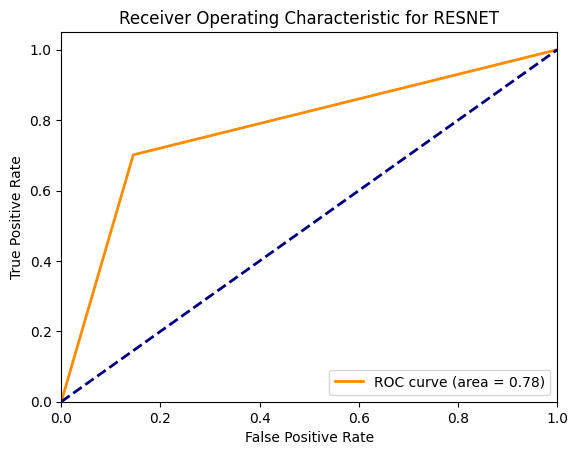

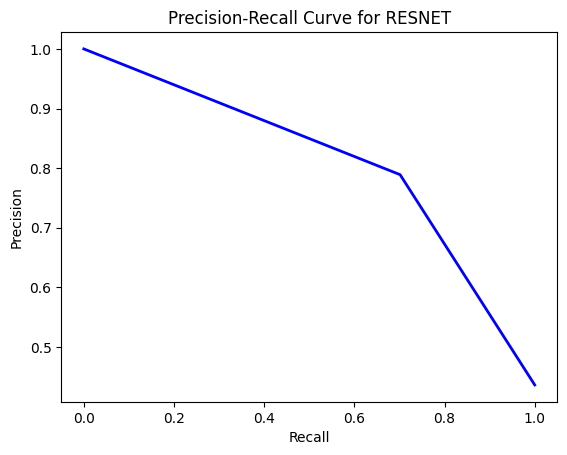

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_resnet)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"RESNET"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_resnet)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"RESNET"}')
    plt.show()

evaluate_model(model_resnet, xtest, ytest, "RESNET")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_resnet[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.7901
Standard deviation of accuracy: 0.0222
95% confidence interval for accuracy: [0.7818, 0.7984]


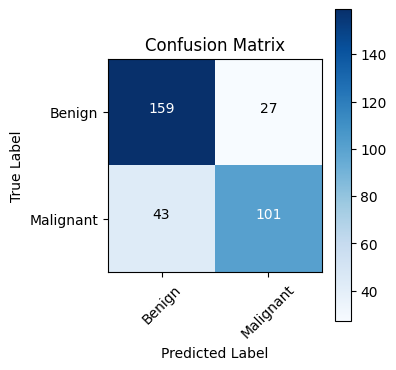

In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_resnet)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**Densenet**

In [ ]:

if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Build the model
model1 = Sequential()
model1.add(DenseNet121(include_top=False, input_shape=(224, 224, 3)))
model1.add(Flatten())
model1.add(Dense(32))
model1.add(LeakyReLU(0.001))
model1.add(Dense(16))
model1.add(LeakyReLU(0.001))
model1.add(Dense(1, activation='sigmoid'))
model1.layers[0].trainable = False

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_9 (Dense)             (None, 32)                1605664   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
# Train the model
N_EPOCHS = 20

# Train the model with GPU
with tf.device('/GPU:0'):
    h3 = model1.fit(xtra, ytra, validation_data=(xval, yval), epochs=N_EPOCHS, batch_size=64)

# Calculate the training time
training_time_dense = end_time - start_time

# Add the training time to the history
h3.history['training_time_dense'] = training_time_dense
print(training_time_dense)

Epoch 1/20
89/89 [==============================] - 14s 92ms/step - loss: 0.4454 - acc: 0.7951 - val_loss: 0.2635 - val_acc: 0.8792
Epoch 2/20
89/89 [==============================] - 6s 69ms/step - loss: 0.2792 - acc: 0.8730 - val_loss: 0.2903 - val_acc: 0.8456
Epoch 3/20
89/89 [==============================] - 6s 70ms/step - loss: 0.2200 - acc: 0.9031 - val_loss: 0.2420 - val_acc: 0.8591
Epoch 4/20
89/89 [==============================] - 6s 70ms/step - loss: 0.1689 - acc: 0.9297 - val_loss: 0.2384 - val_acc: 0.8792
Epoch 5/20
89/89 [==============================] - 6s 71ms/step - loss: 0.1240 - acc: 0.9574 - val_loss: 0.2808 - val_acc: 0.8725
Epoch 6/20
89/89 [==============================] - 6s 70ms/step - loss: 0.0956 - acc: 0.9679 - val_loss: 0.2500 - val_acc: 0.8725
Epoch 7/20
89/89 [==============================] - 6s 70ms/step - loss: 0.0758 - acc: 0.9736 - val_loss: 0.3263 - val_acc: 0.8926
Epoch 8/20
89/89 [==============================] - 6s 69ms/step - loss: 0.0601 - 

In [ ]:
model1.save('/content/drive/MyDrive/cancer_dataset/output/modeldensenet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
## loading previously saved model after training
model_densenet = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/modeldensenet.h5')

In [ ]:
y_pred_densenet = model_densenet.predict(xtest)

11/11 [==============================] - 78s 7s/step


In [ ]:
y_pred_densenet = y_pred_densenet.flatten()

In [ ]:
y_pred_densenet = y_pred_densenet.astype(float)

In [ ]:
y_pred_densenet = np.where(y_pred_densenet > 0.5, 1, 0)

In [ ]:
## confusion matrix

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_densenet)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[163  23]
 [ 22 122]]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_densenet))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       186
           1       0.84      0.85      0.84       144

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



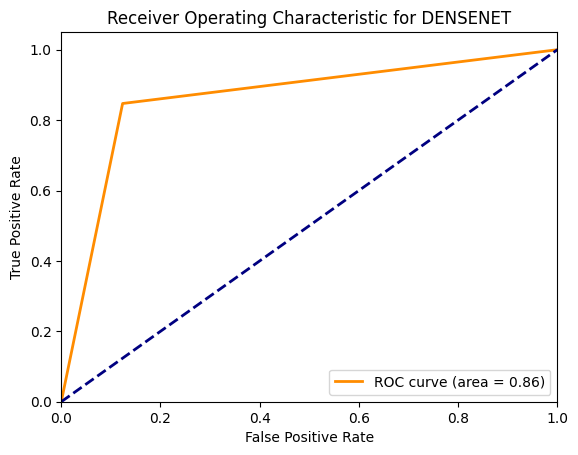

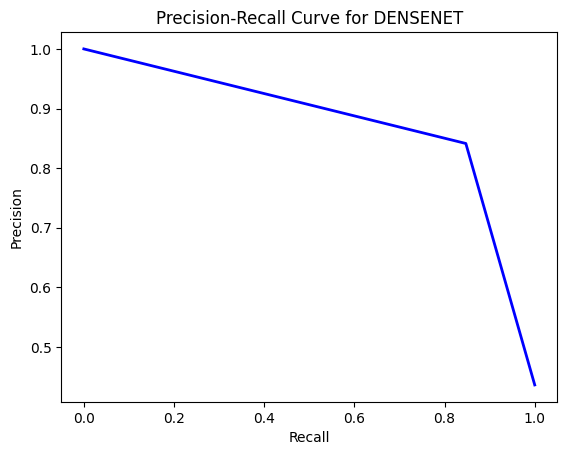

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_densenet)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"DENSENET"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_densenet)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"DENSENET"}')
    plt.show()

evaluate_model(model_resnet, xtest, ytest, "DENSENET")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_densenet[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8631
Standard deviation of accuracy: 0.0197
95% confidence interval for accuracy: [0.8558, 0.8705]


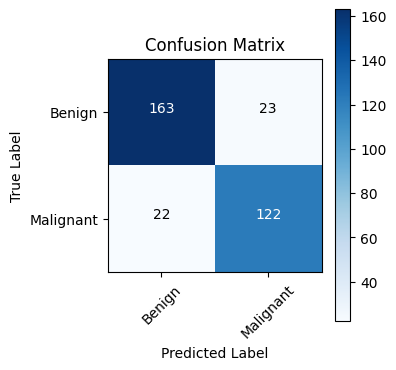

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_densenet)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**inceptionnet**

In [ ]:

# Check if GPU is available and set as the physical device
if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Build the model
model = Sequential()
model.add(InceptionV3(include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_20 (Dense)            (None, 32)                1638432   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16)                0         
                                                       

In [ ]:
# Train the model
N_EPOCHS = 20

# Train the model with GPU
with tf.device('/GPU:0'):
    h1 = model.fit(xtra, ytra, validation_data=(xval, yval), epochs=N_EPOCHS, batch_size=64)

# Calculate the training time
training_time_inc = end_time - start_time

# Add the training time to the history
h1.history['training_time_inc'] = training_time_inc
print(training_time_inc)

Epoch 1/20
89/89 [==============================] - 11s 56ms/step - loss: 0.4975 - acc: 0.7850 - val_loss: 0.3268 - val_acc: 0.8725
Epoch 2/20
89/89 [==============================] - 3s 29ms/step - loss: 0.3344 - acc: 0.8538 - val_loss: 0.6026 - val_acc: 0.7047
Epoch 3/20
89/89 [==============================] - 3s 29ms/step - loss: 0.2597 - acc: 0.8907 - val_loss: 0.3530 - val_acc: 0.8389
Epoch 4/20
89/89 [==============================] - 3s 29ms/step - loss: 0.2033 - acc: 0.9191 - val_loss: 0.4760 - val_acc: 0.8255
Epoch 5/20
89/89 [==============================] - 3s 29ms/step - loss: 0.1826 - acc: 0.9262 - val_loss: 0.3150 - val_acc: 0.8389
Epoch 6/20
89/89 [==============================] - 3s 30ms/step - loss: 0.1389 - acc: 0.9461 - val_loss: 0.5118 - val_acc: 0.8456
Epoch 7/20
89/89 [==============================] - 3s 29ms/step - loss: 0.0829 - acc: 0.9709 - val_loss: 0.3797 - val_acc: 0.8322
Epoch 8/20
89/89 [==============================] - 3s 30ms/step - loss: 0.0432 - 

In [ ]:
model.save('/content/drive/MyDrive/cancer_dataset/output/modelincepnet.h5')

In [ ]:
## loading previously saved model after training
model_incepnet = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/modelincepnet.h5')

In [ ]:
y_pred_modelincepnet = model_incepnet.predict(xtest)

11/11 [==============================] - 49s 4s/step


In [ ]:
y_pred_modelincepnet = y_pred_modelincepnet.flatten()

In [ ]:
y_pred_modelincepnet = y_pred_modelincepnet.astype(float)

In [ ]:
y_pred_modelincepnet= np.where(y_pred_modelincepnet > 0.5, 1, 0)

In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modelincepnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[161  25]
 [ 36 108]]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_modelincepnet))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       186
           1       0.81      0.75      0.78       144

    accuracy                           0.82       330
   macro avg       0.81      0.81      0.81       330
weighted avg       0.81      0.82      0.81       330



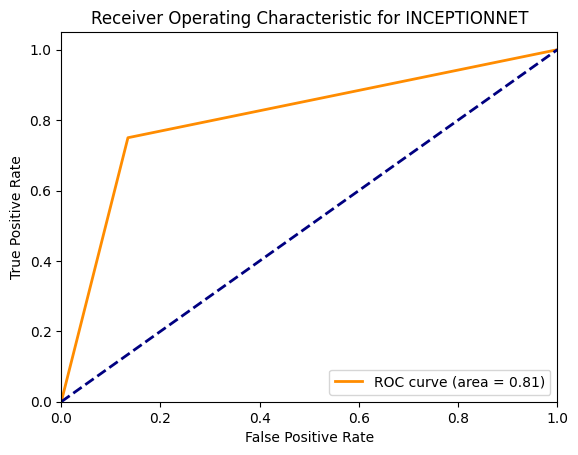

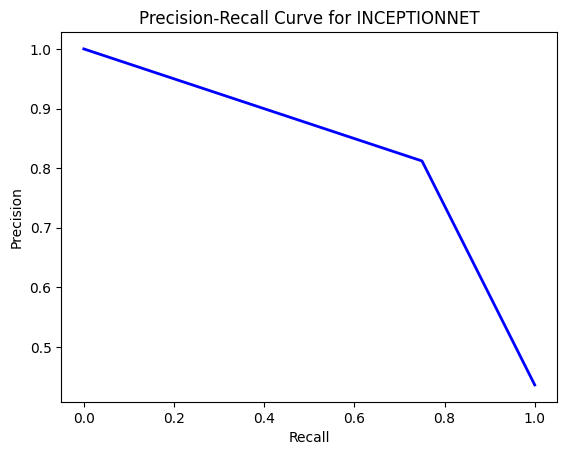

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_modelincepnet)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"INCEPTIONNET"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_modelincepnet)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"INCEPTIONNET"}')
    plt.show()

evaluate_model(model_incepnet, xtest, ytest, "INCEPTIONNET")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_modelincepnet[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8163
Standard deviation of accuracy: 0.0275
95% confidence interval for accuracy: [0.8060, 0.8265]


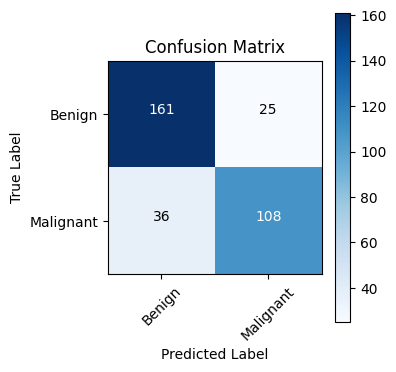

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modelincepnet)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**EfficientNetB0**

In [ ]:

# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Train the model
N_EPOCHS = 20

# Train the model with GPU
with tf.device('/GPU:0'):
    h2 = model.fit(xtra, ytra, validation_data=(xval, yval), epochs=N_EPOCHS, batch_size=64)

# Calculate the training time
training_time_eff = end_time - start_time

# Add the training time to the history
h2.history['training_time_eff'] = training_time_eff
print(training_time_eff)

Epoch 1/20
45/45 [==============================] - 14s 138ms/step - loss: 0.6089 - accuracy: 0.6288 - val_loss: 0.4267 - val_accuracy: 0.7919
Epoch 2/20
45/45 [==============================] - 4s 97ms/step - loss: 0.4839 - accuracy: 0.7566 - val_loss: 0.4726 - val_accuracy: 0.7785
Epoch 3/20
45/45 [==============================] - 4s 92ms/step - loss: 0.4320 - accuracy: 0.7764 - val_loss: 0.3854 - val_accuracy: 0.8322
Epoch 4/20
45/45 [==============================] - 4s 99ms/step - loss: 0.4118 - accuracy: 0.7974 - val_loss: 0.3476 - val_accuracy: 0.8591
Epoch 5/20
45/45 [==============================] - 4s 100ms/step - loss: 0.3960 - accuracy: 0.8052 - val_loss: 0.3623 - val_accuracy: 0.8389
Epoch 6/20
45/45 [==============================] - 4s 93ms/step - loss: 0.3863 - accuracy: 0.8151 - val_loss: 0.3637 - val_accuracy: 0.8523
Epoch 7/20
45/45 [==============================] - 4s 94ms/step - loss: 0.4096 - accuracy: 0.7981 - val_loss: 0.5911 - val_accuracy: 0.7651
Epoch 8/20

In [ ]:
model.save('/content/drive/MyDrive/cancer_dataset/output/modeleffnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
## loading previously saved model after training
model_effnet = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/modeleffnet.h5')

In [ ]:
y_pred_modeleffnet = model_effnet.predict(xtest)

11/11 [==============================] - 11s 945ms/step


In [ ]:
y_pred_modeleffnet = y_pred_modeleffnet.flatten()

In [ ]:
y_pred_modeleffnet = y_pred_modeleffnet.astype(float)

In [ ]:
y_pred_modeleffnet= np.where(y_pred_modeleffnet > 0.5, 1, 0)

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modeleffnet)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[155  31]
 [ 21 123]]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_modeleffnet))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       186
           1       0.80      0.85      0.83       144

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



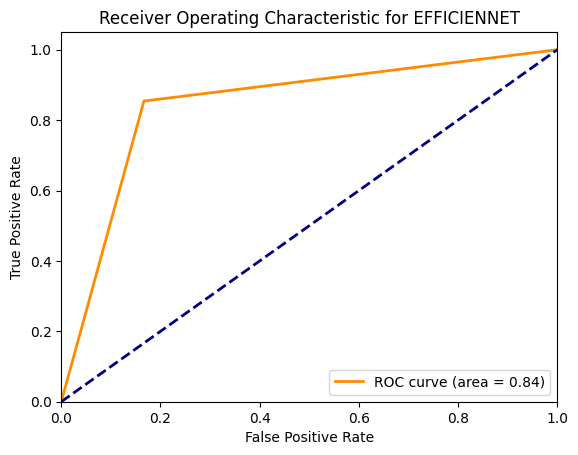

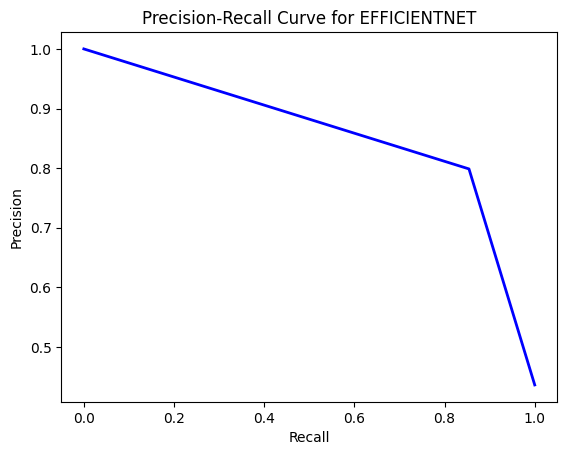

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_modeleffnet)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"EFFICIENNET"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_modeleffnet)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"EFFICIENTNET"}')
    plt.show()

evaluate_model(model_effnet, xtest, ytest, "EFFICIENTNET")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_modeleffnet[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8474
Standard deviation of accuracy: 0.0167
95% confidence interval for accuracy: [0.8411, 0.8536]


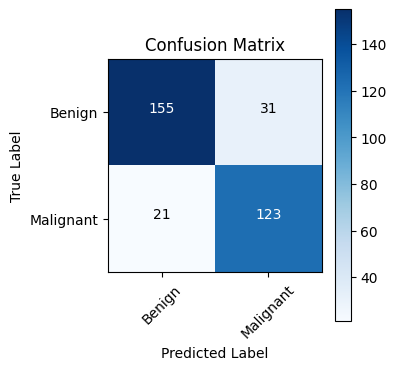

In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modeleffnet)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


**CNN**

In [ ]:

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

# Train the model
with tf.device('/GPU:0'):
  h5 = model.fit(xtra, ytra, validation_data=(xval, yval), epochs=20, batch_size=64)


# Calculate the training time
training_time_cnn = end_time - start_time

# Add the training time to the history
h5.history['training_time_cnn'] = training_time_cnn
print(training_time_cnn)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
model.save('/content/drive/MyDrive/cancer_dataset/output/cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/cancer_dataset/output/cnn.h5')

In [ ]:
y_pred_modelcnn = model_cnn.predict(xtest)

11/11 [==============================] - 26s 2s/step


In [ ]:
y_pred_modelecnn = y_pred_modelcnn.flatten()

In [ ]:
y_pred_modelcnn = y_pred_modelcnn.astype(float)

In [ ]:
y_pred_modelcnn= np.where(y_pred_modelcnn > 0.5, 1, 0)

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modelcnn)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[141  45]
 [ 22 122]]


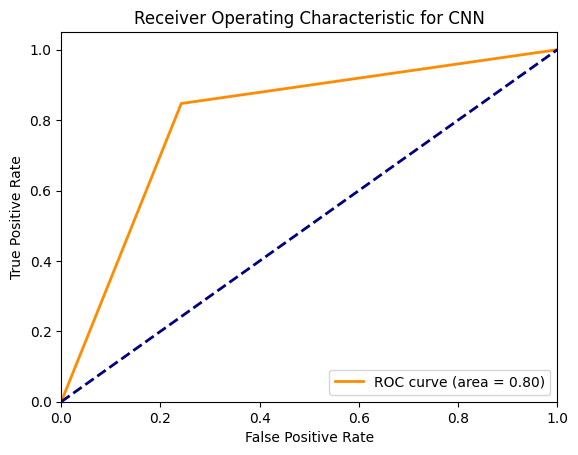

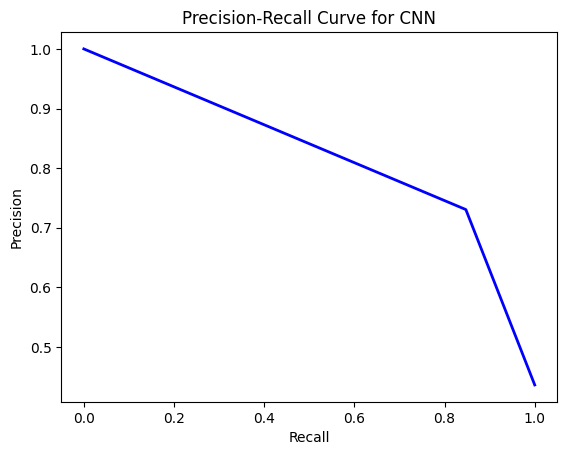

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_pred_modelcnn)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"CNN"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, y_pred_modelcnn)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"CNN"}')
    plt.show()

evaluate_model(model_cnn, xtest, ytest, "CNN")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = y_pred_modelcnn[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.4996
Standard deviation of accuracy: 0.0028
95% confidence interval for accuracy: [0.4986, 0.5006]


In [ ]:
## classification report
print(classification_report(ytest, y_pred_modelcnn))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       186
           1       0.73      0.85      0.78       144

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.81      0.80      0.80       330



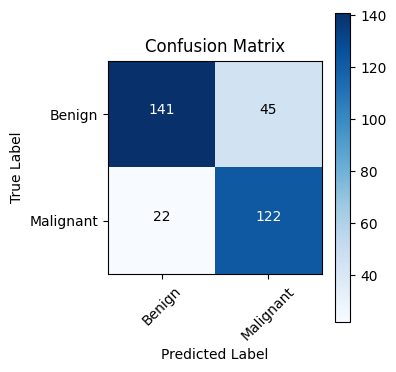

In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(ytest, y_pred_modelcnn)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**SVM**

In [ ]:


train_images_flat = xtra.reshape(xtra.shape[0], -1)
test_images_flat = xtest.reshape(xtest.shape[0], -1)
# Initialize the SVM classifier
svm = SVC(kernel='rbf')

# Train the SVM classifier
svm.fit(train_images_flat, ytra)

# Make predictions on the test set
predictions = svm.predict(test_images_flat)

# Evaluate the accuracy of the SVM classifier
accuracy = accuracy_score(ytest, predictions)
print("SVM Accuracy:", accuracy)




SVM Accuracy: 0.8333333333333334


In [ ]:

# Save the trained model
joblib.dump(svm, '/content/drive/MyDrive/cancer_dataset/output/svm_model.pkl')

# Load the saved model
loaded_model = joblib.load('/content/drive/MyDrive/cancer_dataset/output/svm_model.pkl')

# Make predictions on the test set
predictions = loaded_model.predict(test_images_flat)

# Evaluate the accuracy of the SVM classifier
accuracy = accuracy_score(ytest, predictions)


# Generate a classification report
report = classification_report(ytest, predictions)
print("Classification Report:")
print(report)




Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       186
           1       0.78      0.85      0.82       144

    accuracy                           0.83       330
   macro avg       0.83      0.84      0.83       330
weighted avg       0.84      0.83      0.83       330



In [ ]:
# Create a confusion matrix
cm = confusion_matrix(ytest, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[152  34]
 [ 21 123]]


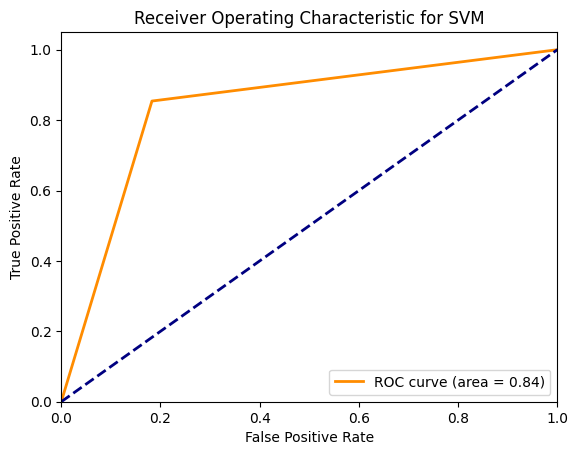

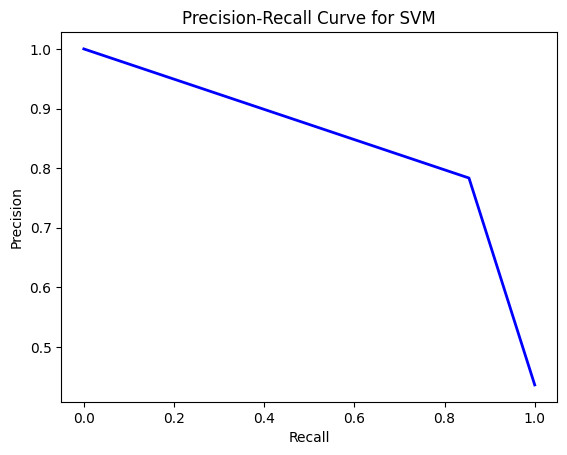

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"SVM"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, predictions)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"SVM"}')
    plt.show()

evaluate_model(loaded_model, xtest, ytest, "SVM")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = predictions[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8335
Standard deviation of accuracy: 0.0187
95% confidence interval for accuracy: [0.8266, 0.8405]


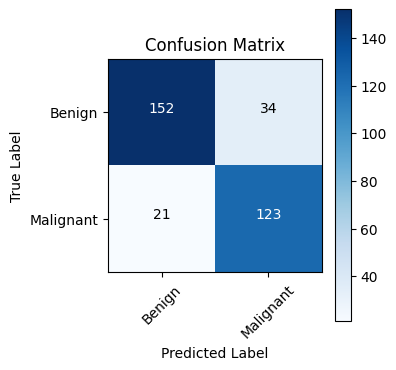

In [ ]:


# Compute the confusion matrix
cm = confusion_matrix(ytest, predictions)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**Random forest classifier**

In [ ]:



# Reshape the training and test images if needed
train_images_flat = xtra.reshape(xtra.shape[0], -1)
test_images_flat = xtest.reshape(xtest.shape[0], -1)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest Classifier
rf_classifier.fit(train_images_flat, ytra)

# Make predictions on the test set
predictions_rf = rf_classifier.predict(test_images_flat)

# Evaluate the accuracy of the Random Forest Classifier
accuracy = accuracy_score(ytest, predictions)
print("Random Forest Accuracy:", accuracy)


Random Forest Accuracy: 0.8333333333333334


In [ ]:

# Save the trained model
#joblib.dump(rf_classifier, '/content/drive/MyDrive/cancer_dataset/output/rf_model.pkl')

# Load the saved model
loaded_model_rf = joblib.load('/content/drive/MyDrive/cancer_dataset/output/rf_model.pkl')

# Make predictions on the test set
predictions_rf = loaded_model.predict(test_images_flat)

# Evaluate the accuracy of the SVM classifier
accuracy = accuracy_score(ytest, predictions)


# Generate a classification report
report = classification_report(ytest, predictions_rf)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       186
           1       0.78      0.85      0.82       144

    accuracy                           0.83       330
   macro avg       0.83      0.84      0.83       330
weighted avg       0.84      0.83      0.83       330



In [ ]:
# Create a confusion matrix
cm = confusion_matrix(ytest, predictions_rf)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[151  35]
 [ 25 119]]


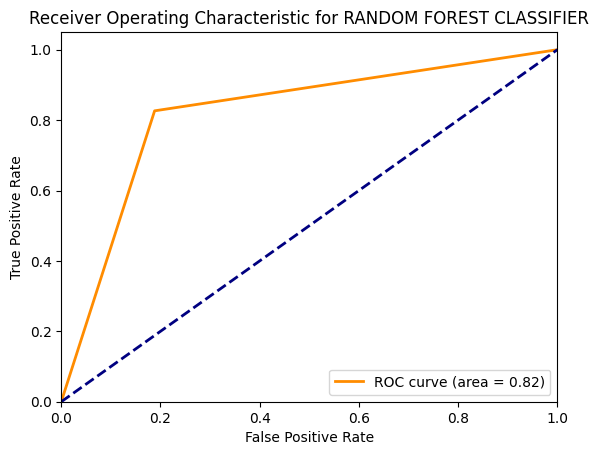

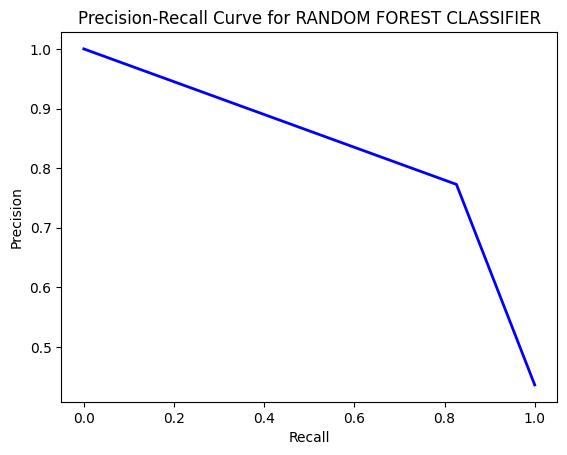

In [ ]:
def evaluate_model(model, xtest, ytest, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(ytest, predictions_rf)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {"RANDOM FOREST CLASSIFIER"}')
    plt.legend(loc="lower right")
    plt.show()

     # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(ytest, predictions_rf)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {"RANDOM FOREST CLASSIFIER"}')
    plt.show()

evaluate_model(loaded_model_rf, xtest, ytest, "RANDOM FOREST CLASSIFIER")



In [ ]:
n_experiments = 30  # Number of repetitions for bootstrapping
accuracy_list = []

for i in range(n_experiments):
    # Bootstrap sampling
    indices = np.random.choice(len(ytest), len(ytest), replace=True)
    ytest_sample = ytest[indices]
    ypred_sample = predictions_rf[indices]

    # Compute accuracy
    accuracy = np.mean(ypred_sample == ytest_sample)
    accuracy_list.append(accuracy)

# Calculate mean and standard deviation of accuracy
mean_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)

print(f"Mean accuracy after {n_experiments} bootstrapping experiments: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

# Confidence Interval for accuracy
ci_low, ci_high = stats.t.interval(0.95, len(accuracy_list)-1, loc=mean_accuracy, scale=std_accuracy/np.sqrt(len(accuracy_list)))
print(f"95% confidence interval for accuracy: [{ci_low:.4f}, {ci_high:.4f}]")

Mean accuracy after 30 bootstrapping experiments: 0.8165
Standard deviation of accuracy: 0.0206
95% confidence interval for accuracy: [0.8088, 0.8242]


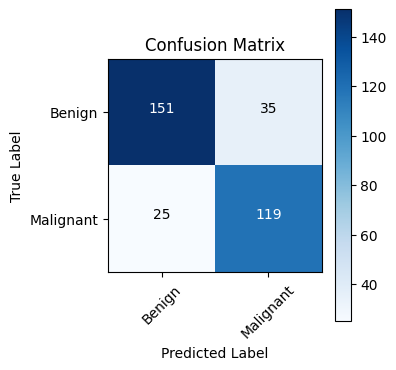

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(ytest, predictions_rf)

# Define class labels
class_labels = ['Benign', 'Malignant']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Fill the matrix with values
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
# Convert probabilities to binary predictions (assuming binary classification)
y_pred_vgg_bin = (y_pred_vgg > 0.5).astype(int).reshape(-1)
y_pred_resnet_bin = (y_pred_resnet > 0.5).astype(int).reshape(-1)
y_pred_densenet_bin = (y_pred_densenet > 0.5).astype(int).reshape(-1)
y_pred_modelincepnet_bin = (y_pred_modelincepnet > 0.5).astype(int).reshape(-1)
y_pred_efficientnet_bin = (y_pred_modeleffnet > 0.5).astype(int).reshape(-1)
y_pred_modelcnn_bin = (y_pred_modelcnn > 0.5).astype(int).reshape(-1)
y_pred_loaded_model_rf_bin = (predictions_rf > 0.5).astype(int).reshape(-1)
y_pred_loaded_model_svm_bin = (predictions > 0.5).astype(int).reshape(-1)

# Ensure ytest is a 1D array
if len(ytest.shape) > 1 and ytest.shape[1] > 1:
    ytest = np.argmax(ytest, axis=1)

# Majority Voting: Combine predictions from all classifiers
# Average predictions from each model, then apply threshold
combined_predictions = np.round(
    (y_pred_vgg_bin + y_pred_resnet_bin + y_pred_densenet_bin +
     y_pred_modelincepnet_bin + y_pred_efficientnet_bin +
     y_pred_modelcnn_bin + y_pred_loaded_model_rf_bin +
     y_pred_loaded_model_svm_bin) / 8
).astype(int)

# Ensure combined_predictions is a 1D array
if combined_predictions.ndim > 1:
    combined_predictions = combined_predictions.flatten()

# Evaluate the accuracy of the combined classifier
accuracy = accuracy_score(ytest, combined_predictions)
print(f'Accuracy of the fused classifier: {accuracy:.4f}')


Accuracy of the fused classifier: 0.8636


In [ ]:
import os
import pandas as pd
import shutil

# Paths to your ISIC 2019 images and metadata file
image_dir = '/path/to/ISIC_2019_Training_Input'  # Folder containing all the images
metadata_path = '/path/to/metadata.csv'  # Metadata CSV file

# Output directories
benign_dir = '/path/to/benign_images'
malignant_dir = '/path/to/malignant_images'

# Create directories if they don't exist
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# Load the metadata
metadata = pd.read_csv(metadata_path)

# Iterate through the metadata and separate images
for index, row in metadata.iterrows():
    image_name = row['isic_id'] + '.jpg'  # Assuming the images have a .jpg extension
    image_path = os.path.join(image_dir, image_name)

    if row['target'] == 0:
        shutil.copy(image_path, os.path.join(benign_dir, image_name))
    elif row['target'] == 1:
        shutil.copy(image_path, os.path.join(malignant_dir, image_name))

print("Images have been separated successfully!")


In [ ]:
## https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-224x224-resized/data